In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/braintp01/tp1_instructions_v2023-09-20_145355.pdf
/kaggle/input/braintp01/Ronneberger et al. - 2015 - U-net Convolutional networks for biomedical image.pdf
/kaggle/input/braintp01/conv_net.pdf
/kaggle/input/braintp01/iSeg-2017-Testing/subject-11-T2.hdr
/kaggle/input/braintp01/iSeg-2017-Testing/subject-20-T2.img
/kaggle/input/braintp01/iSeg-2017-Testing/subject-23-T1.img
/kaggle/input/braintp01/iSeg-2017-Testing/subject-13-T1.hdr
/kaggle/input/braintp01/iSeg-2017-Testing/subject-17-T1.img
/kaggle/input/braintp01/iSeg-2017-Testing/subject-16-T2.hdr
/kaggle/input/braintp01/iSeg-2017-Testing/subject-19-T2.hdr
/kaggle/input/braintp01/iSeg-2017-Testing/subject-14-T1.img
/kaggle/input/braintp01/iSeg-2017-Testing/subject-19-T1.hdr
/kaggle/input/braintp01/iSeg-2017-Testing/subject-13-T1.img
/kaggle/input/braintp01/iSeg-2017-Testing/subject-20-T2.hdr
/kaggle/input/braintp01/iSeg-2017-Testing/subject-18-T1.hdr
/kaggle/input/braintp01/iSeg-2017-Testing/subject-18-T2.hdr
/kaggle/input

In [2]:
from keras.models import *
from keras.optimizers import *
import nibabel as nib
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
DATA = "/kaggle/input/braintp01/"
TRAIN_PATH = DATA + "iSeg-2017-Training/"
TEST_PATH = DATA + "iSeg-2017-Testing/"

In [4]:
gt_ = nib.load(TRAIN_PATH +"subject-10-label.hdr").get_fdata().squeeze()
t1_ = nib.load(TRAIN_PATH +"subject-10-T1.hdr").get_fdata().squeeze()
t2_ = nib.load(TRAIN_PATH +"subject-10-T2.hdr").get_fdata().squeeze()

## Display

In [5]:
def display_mri_slices(gt, t1, t2, slice_idx=None):
    """
    Affiche une coupe transversale des images IRM GT, T1 et T2.
    
    Parameters:
    - gt (numpy.ndarray): Volume 3D de segmentation (étiquettes).
    - t1 (numpy.ndarray): Volume 3D de l'image pondérée T1.
    - t2 (numpy.ndarray): Volume 3D de l'image pondérée T2.
    - slice_idx (int, optional): Index de la coupe à visualiser. Si None, la coupe médiane est utilisée.
    """
    
    if slice_idx is None:
        slice_idx = gt.shape[2] // 2  # Sélection d'une coupe médiane pour la visualisation

    plt.figure(figsize=(18, 6))

    # Affichage de l'image T1
    plt.subplot(1, 3, 1)
    plt.imshow(t1[:, :, slice_idx], cmap='gray')
    plt.title('T1-Weighted Image')
    plt.axis('off')

    # Affichage de l'image T2
    plt.subplot(1, 3, 2)
    plt.imshow(t2[:, :, slice_idx], cmap='gray')
    plt.title('T2-Weighted Image')
    plt.axis('off')

    # Affichage de la segmentation
    plt.subplot(1, 3, 3)
    plt.imshow(gt[:, :, slice_idx], cmap='tab20b')  # Utilisation d'une carte de couleurs différente pour la segmentation
    plt.title('Ground Truth Segmentation')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

==> Slice: 50


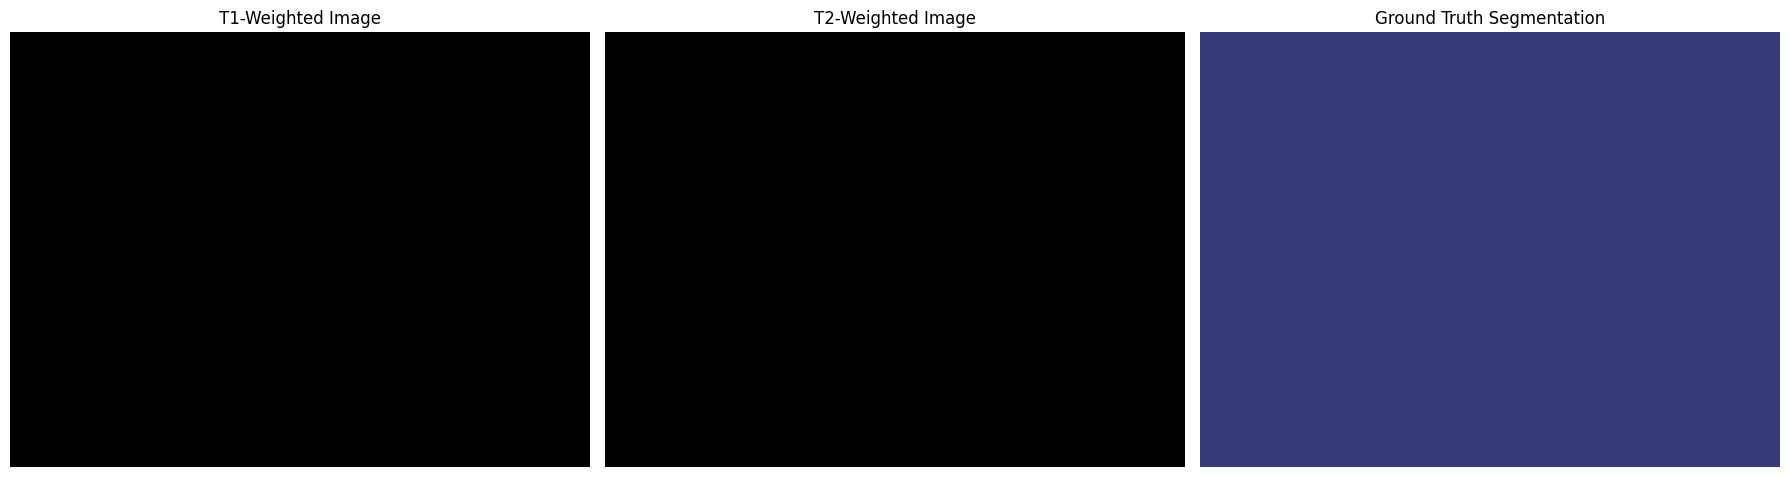

==> Slice: 100


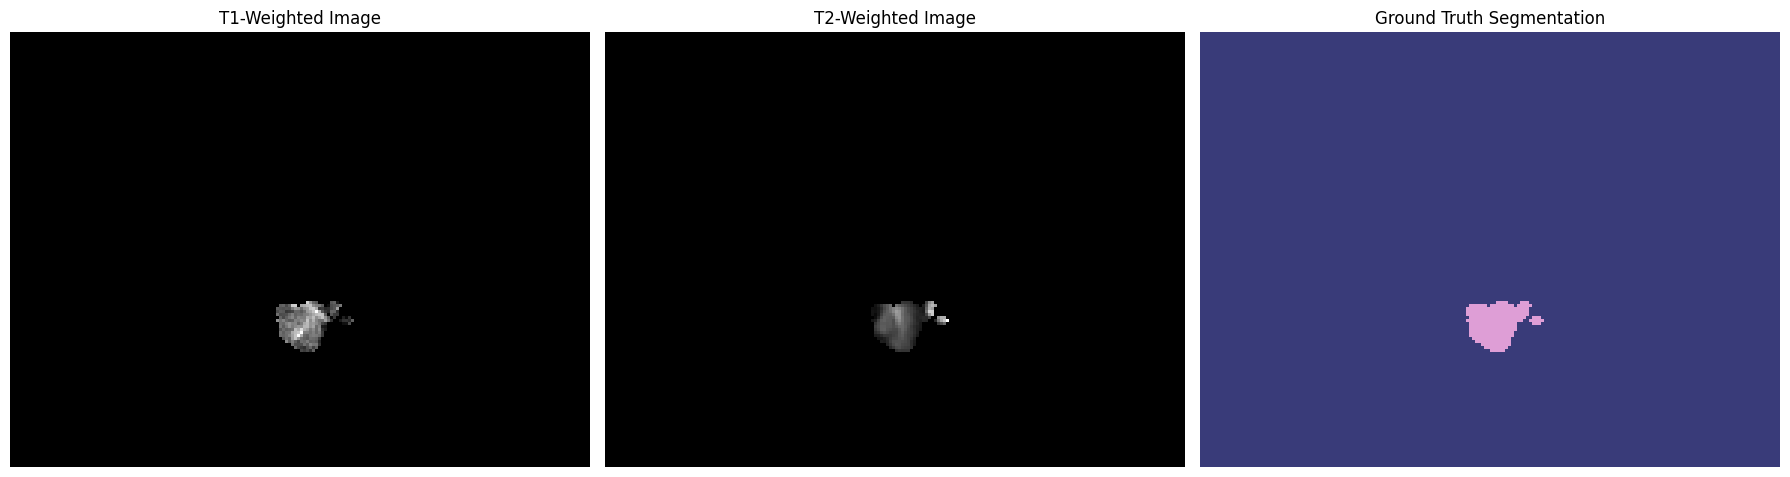

==> Slice: 150


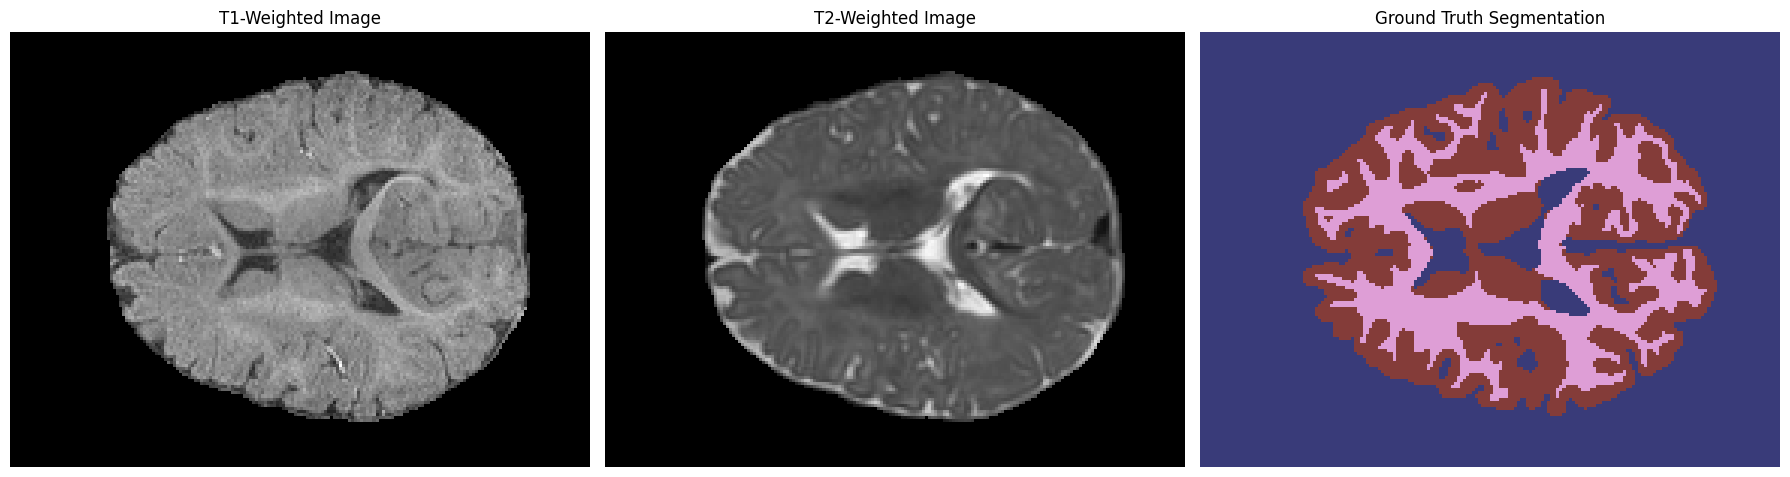

==> Slice: 200


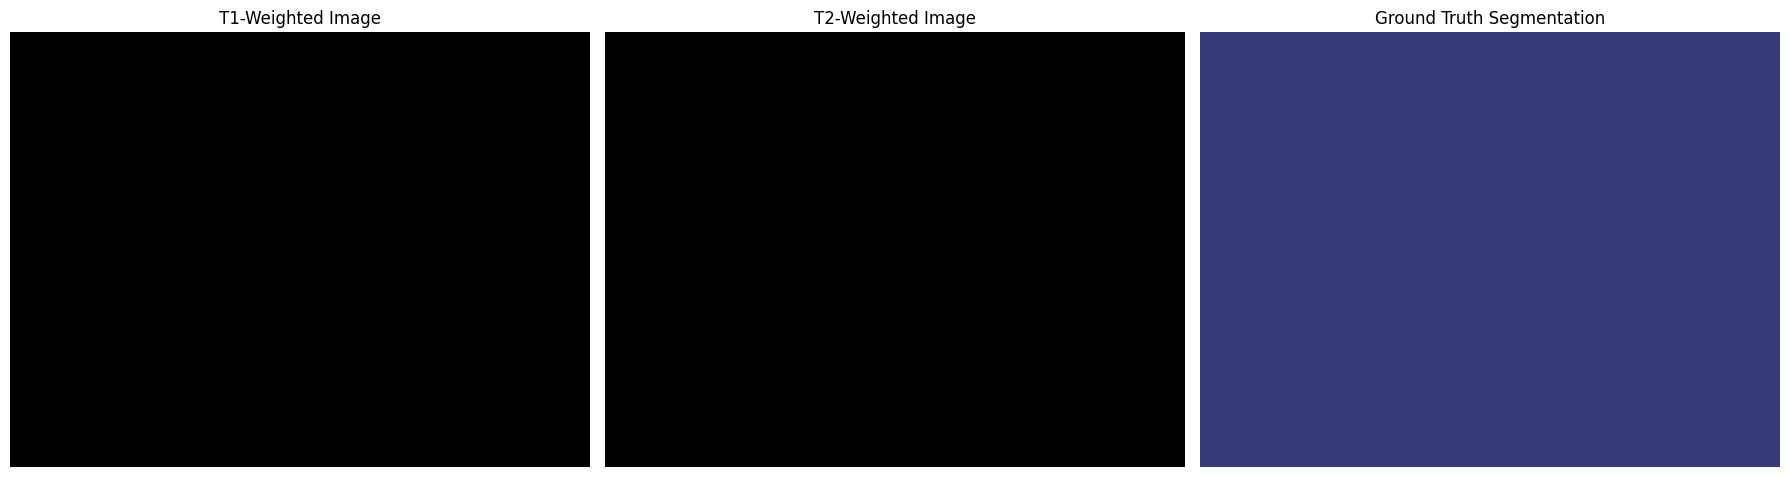

In [6]:
for i in range(50, 250, 50):
    print(f"==> Slice: {i}") 
    display_mri_slices(gt_, t1_, t2_, i)

## Histogram

In [7]:
def compute_histogram(data, labels):
    hist = [np.sum(data == label) for label in labels]
    return hist

def plot_histograms(data1, data2, data3, labels):
    hist1 = compute_histogram(data1, labels)
    hist2 = compute_histogram(data2, labels)
    hist3 = compute_histogram(data3, labels)
    
    bar_width = 0.35
    index = np.arange(len(labels))
    
    fig, ax = plt.subplots()
    bar1 = ax.bar(index, hist1, bar_width, label='gt', color='b')
    bar2 = ax.bar(index + bar_width, hist2, bar_width, label='t1', color='r')
    bar3 = ax.bar(index + bar_width * 2, hist3, bar_width, label='t2', color='g')
    
    ax.set_xlabel('Labels')
    ax.set_ylabel('Nombre de valeurs')
    ax.set_title('Histogramme des labels pour gt, t1 et t2')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()

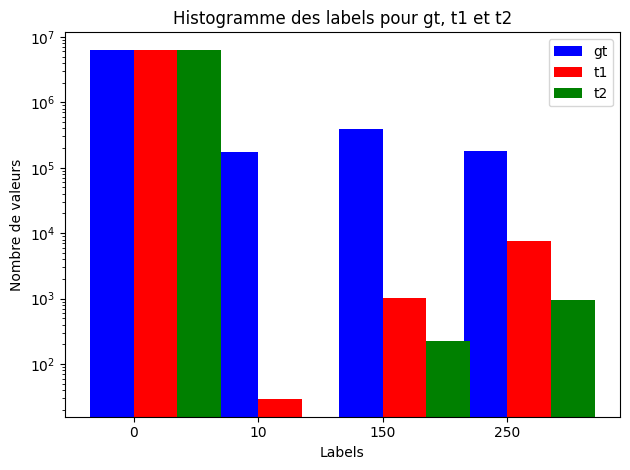

In [8]:
labels = [0, 10, 150, 250]
plot_histograms(gt_, t1_, t2_, labels)

In [9]:
class SlicesGenerator(keras.utils.Sequence):
    def __init__(self, data, gt, batch_size=8):
        self.data = data # input
        self.gt = gt # ground true
        self.batch_size = batch_size
    
    def __len__(self):
        return 1000

    def __getitem__(self, idx):
        #ax = np.random.randint(3)
        ax = 2
        va = np.random.randint(self.data.shape[0])
        img = self.data[va]
        img_gt = self.gt[va]
        
        valid_slice_found = False
        while not valid_slice_found:
            if ax == 0:
                idx_slices = np.random.randint(0, self.data.shape[ax], 8)
                image_batch = img[idx_slices, ...]
            elif ax == 1:
                idx_slices = np.random.randint(0, self.data.shape[ax], 8)
                image_batch = img[:, idx_slices, :, :].transpose(1, 0, 2, 3)
            elif ax == 2:
                idx_slices = np.random.randint(0, self.data.shape[ax], 8)
                image_batch = img[:, :, idx_slices, :].transpose(2, 0, 1, 3)
            
            valid_slice_found = np.any(image_batch[0, :, :, 1])

        if ax == 0:
            return img[idx_slices, ...], img_gt[idx_slices, ...]
        elif ax == 1:
            return img[:, idx_slices, :, :].transpose(1, 0, 2, 3), img_gt[:, idx_slices, :, :].transpose(1, 0, 2, 3)
        elif ax == 2:
            return img[:, :, idx_slices, :].transpose(2, 0, 1, 3), img_gt[:, :, idx_slices, :].transpose(2, 0, 1, 3)

In [10]:
def generate_binary_slices(gt, labels):
    binary_slices = {}
        
    for label in labels:
        binary_slices[label] = np.where(gt == label, 1, 0)
    
    return binary_slices

def stack_segmented_volumes(segmented_slices, labels):
    stacked_volume = np.stack([segmented_slices[label] for label in labels], axis=3)
    return stacked_volume

def display_segmented_slices(stacked_slices, labels, names, id_slice):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for i, (ax, name) in enumerate(zip(axes, names)):
        ax.imshow(stacked_slices[id_slice, :, :, i], cmap="gray")
        ax.set_title(name)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

(144, 192, 256, 4)


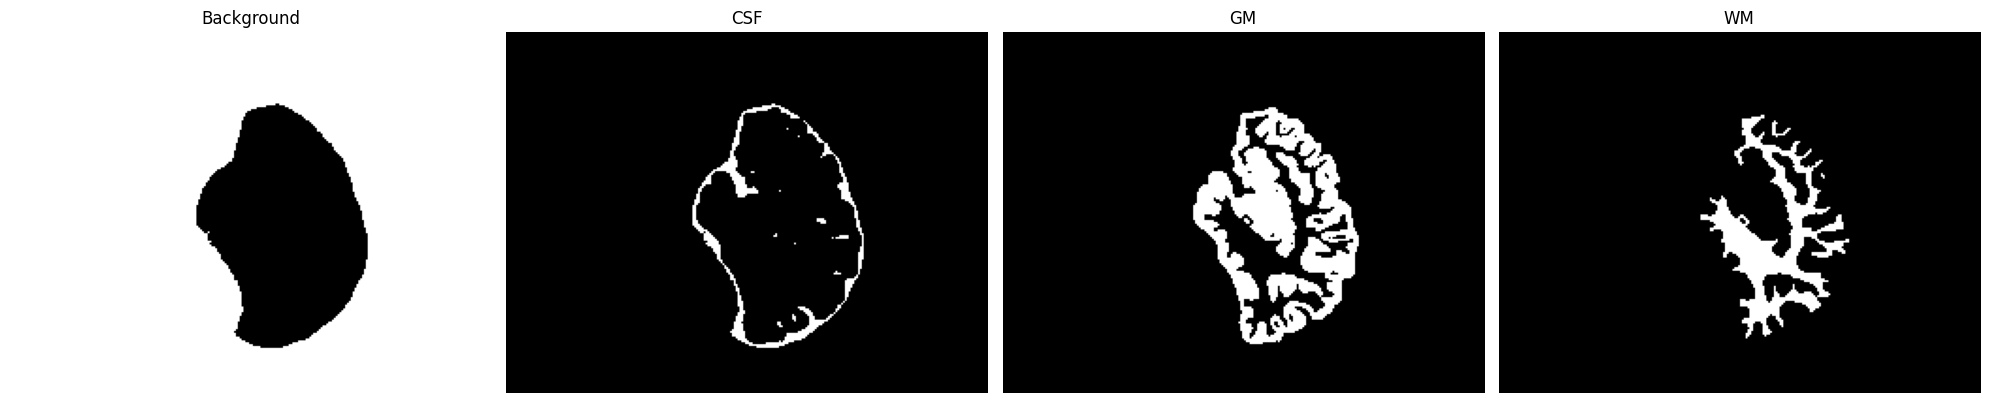

In [11]:
names = ["Background", "CSF", "GM", "WM"]
labels = [0, 10, 150, 250]

slices = generate_binary_slices(gt_, labels)
stacked_slices = stack_segmented_volumes(slices, labels)
print(stacked_slices.shape)

display_segmented_slices(stacked_slices, labels, names, 100)

In [16]:
from keras import layers
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Flatten

def first_model(img_size, num_classes):
    
    inputs = keras.Input(shape=img_size + (2,))

    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])
        previous_block_activation = x

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])
        previous_block_activation = x

    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(
        x
    )

    model = keras.Model(inputs, outputs)
    return model

In [43]:
def normalise(data):
    min_val = np.min(data)
    max_val = np.max(data)
    data_norm = (data - min_val) / (max_val - min_val)
    return data_norm

In [18]:
data = []
gt = []

DATA = "/kaggle/input/braintp01/"
TRAIN_PATH = DATA + "iSeg-2017-Training/"

for i in range(1, 11):
    groundtruth = nib.load(TRAIN_PATH + f"subject-{i}-label.hdr").get_fdata().squeeze()
    
    t1 = nib.load(TRAIN_PATH + f"subject-{i}-T1.hdr").get_fdata().squeeze()
    t2 = nib.load(TRAIN_PATH + f"subject-{i}-T2.hdr").get_fdata().squeeze()
    
    gt0 = groundtruth == 0
    gt1 = groundtruth == 10
    gt2 = groundtruth == 150
    gt3 = groundtruth == 250
    
    t1_norm = normalise(t1)
    t2_norm = normalise(t2)
    
    gt.append(np.stack((gt0, gt1, gt2, gt3), axis=-1))
    data.append(np.stack((t1_norm, t2_norm), axis=-1))

gt = np.array(gt)
data = np.array(data)

print(gt.dtype)
print(gt.shape)

print(data.dtype)
print(data.shape)

bool
(10, 144, 192, 256, 4)
float64
(10, 144, 192, 256, 2)


(8, 144, 192, 4)
True


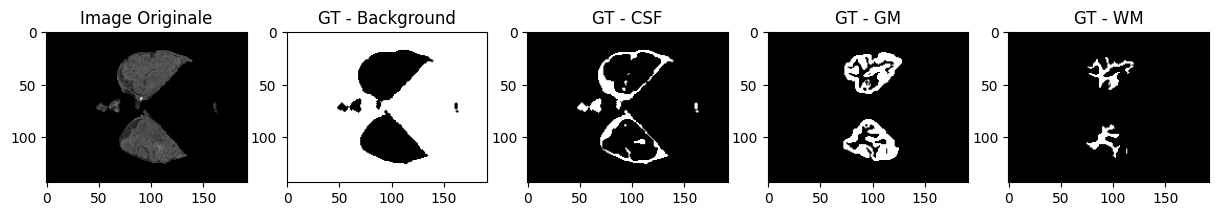

In [19]:
gen = SlicesGenerator(data, gt)
item = gen.__getitem__(2)
image_batch = item[1]
img = item[0]
print(image_batch.shape)

plt.figure(figsize=(15, 8))

plt.subplot(1,5,1)
plt.imshow(img[0, :, :, 0], cmap='gray')
plt.title('Image Originale')

plt.subplot(1,5,2)
plt.imshow(image_batch[0, :, :, 0], cmap='gray')
plt.title('GT - Background')

plt.subplot(1,5,3)
plt.imshow(image_batch[0, :, :, 1], cmap='gray')
plt.title('GT - CSF')

plt.subplot(1,5,4)
plt.imshow(image_batch[0, :, :, 2], cmap='gray')
plt.title('GT - GM')

plt.subplot(1,5,5)
plt.imshow(image_batch[0, :, :, 3], cmap='gray')
plt.title('GT - WM')

valid_slice_found = np.any(image_batch[0, :, :, 1])
print(valid_slice_found)

plt.show()

In [20]:
print('Min:', np.min(img[0, :, :, 0]))
print('Max:', np.max(img[0, :, :, 0]))
print('Mean:', np.mean(img[0, :, :, 0]))
print('Std Dev:', np.std(img[0, :, :, 0]))

Min: 0.0
Max: 0.675
Mean: 0.029490668402777778
Std Dev: 0.07176308355807941


In [21]:
item = gen.__getitem__(2)[0].shape

model = first_model(img_size=(item[1], item[2]), num_classes=4)
print(len(model.layers))
model.summary()

72
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 192, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 72, 96, 32)   608         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 72, 96, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                           

In [22]:
BATCH_SIZE = 16

data_train = data[0:8]
gt_train =  gt[0:8]

data_val = data[8:10]
gt_val = gt[8:10]
  
train_gen = SlicesGenerator(data_train, gt_train, batch_size=BATCH_SIZE)
val_gen = SlicesGenerator(data_val, gt_val, batch_size=BATCH_SIZE)
nb_iter = 30

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=2, mode='auto', restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_gen, validation_data=val_gen, epochs=nb_iter, callbacks=[early_stop])

Epoch 1/30
1000/1000 [==============================] - 86s 76ms/step - loss: 0.1918 - accuracy: 0.9259 - val_loss: 0.1368 - val_accuracy: 0.9365
Epoch 2/30
1000/1000 [==============================] - 74s 74ms/step - loss: 0.1242 - accuracy: 0.9426 - val_loss: 0.1225 - val_accuracy: 0.9423
Epoch 3/30
1000/1000 [==============================] - 75s 75ms/step - loss: 0.1090 - accuracy: 0.9499 - val_loss: 0.1287 - val_accuracy: 0.9409
Epoch 4/30
1000/1000 [==============================] - 75s 75ms/step - loss: 0.0976 - accuracy: 0.9555 - val_loss: 0.1175 - val_accuracy: 0.9463
Epoch 5/30
1000/1000 [==============================] - 74s 74ms/step - loss: 0.0889 - accuracy: 0.9598 - val_loss: 0.1216 - val_accuracy: 0.9464
Epoch 6/30
1000/1000 [==============================] - 74s 74ms/step - loss: 0.0780 - accuracy: 0.9651 - val_loss: 0.1286 - val_accuracy: 0.9454
Epoch 7/30
1000/1000 [==============================] - 75s 75ms/step - loss: 0.0694 - accuracy: 0.9692 - val_loss: 0.1460 -

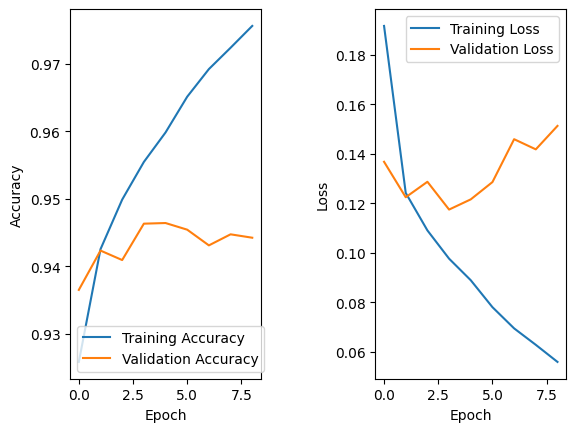

In [23]:
def plot_metrics(history):
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplots_adjust(wspace=0.6)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_metrics(history)

1/1 [==============================] - 0s 22ms/step


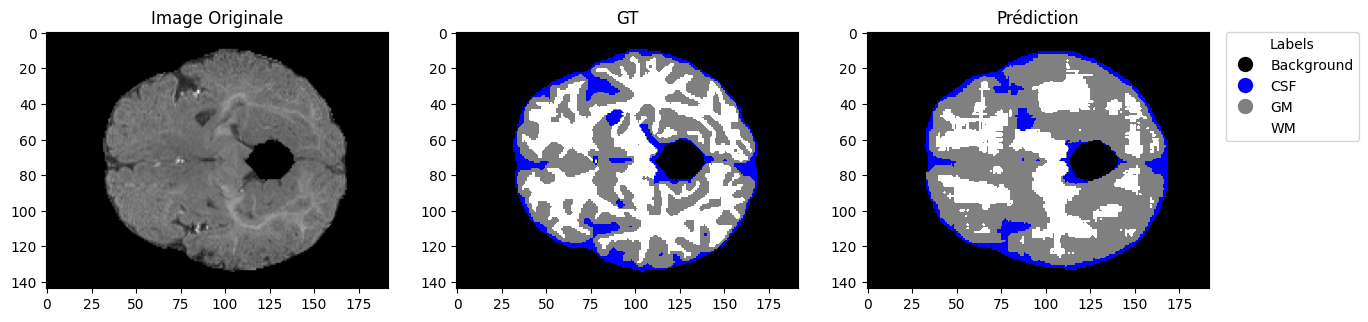

In [36]:
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt

x_val, y_val = val_gen.__getitem__(2)

predictions = model.predict(x_val)

image = x_val[0]
prediction = predictions[0]

predicted_labels = np.argmax(predictions, axis=-1)

predicted_labels_first = predicted_labels[0]

colors = ['black', 'blue', 'gray', 'white']
legend = ['Background', 'CSF', 'GM', 'WM']
cmap = mcolors.ListedColormap(colors)

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(x_val[0, :, :, 0], cmap='gray')
plt.title('Image Originale')

plt.subplot(1, 3, 2)
plt.imshow(np.argmax(y_val[0], axis=-1), cmap=cmap)
plt.title('GT')

plt.subplot(1, 3, 3)
plt.imshow(predicted_labels_first, cmap=cmap)
plt.title('Prédiction')

patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label=f"{legend[i]}")[0]  for i in range(len(colors))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Labels")

plt.show()

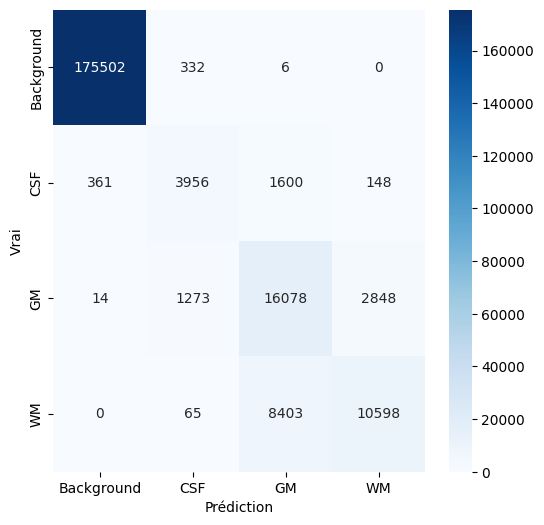

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = np.argmax(y_val, axis=-1).flatten()
predicted_labels = np.argmax(predictions, axis=-1).flatten()

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=legend, yticklabels=legend)
plt.xlabel('Prédiction')
plt.ylabel('Vrai')
plt.show()

In [38]:
from sklearn.metrics import f1_score

true_labels = np.argmax(y_val, axis=-1).flatten()
predicted_labels = np.argmax(predictions, axis=-1).flatten()

dice_score = f1_score(true_labels, predicted_labels, average=None)
dice_error = 1 - dice_score

print(f'DICE Error: {dice_error}')

DICE Error: [0.0020272  0.3232401  0.30548596 0.35101041]


In [46]:
def merge_channels(arr):
    values = [0, 10, 150, 250]

    original_shape = arr.shape[:-1]
    merged_arr = np.zeros(original_shape)

    for channel_idx, value in enumerate(values):
        merged_arr[arr[..., channel_idx]] = value

    return merged_arr.astype(np.uint8)

In [39]:
def predict_and_post_process(entry):
    prediction = model.predict(entry)
    
    prediction = (prediction >= 0.5)
    
    return merge_channels(prediction)

In [44]:
def preprocess_data(t1, t2):
    t1 = normalise(t1)
    t2 = normalise(t2)
    
    return np.concatenate((t1, t2), axis=-1)

In [47]:
TEST_PATH = "/kaggle/input/braintp01/iSeg-2017-Testing"

data_dic = {f'subject-{i}':None for i in range(11, 24)}

for i in range(11, 24):
    data_t1 = nib.load(f'{TEST_PATH}/subject-{i}-T1.img').get_fdata()
    data_t2 = nib.load(f'{TEST_PATH}/subject-{i}-T2.img').get_fdata()
    
    data = preprocess_data(data_t1, data_t2)

    data_dic[f'subject-{i}'] = predict_and_post_process(data)

5/5 [==============================] - 0s 53ms/step


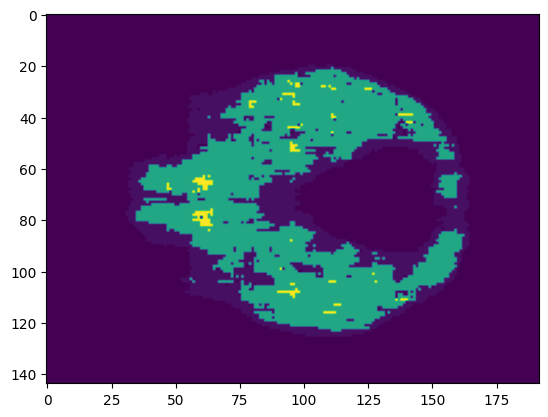

In [48]:
plt.imshow(data_dic['subject-11'][:,:,120])

In [49]:
np.savez("/kaggle/working/brain_labels_TB.npz", **data_dic)